# Preface

While considering which topic to pick to write a tutorial I suddenly understood that there's no better way to show an interesting thing than to describe something you're truly aware of. Alright, I got a higher education in chemistry, then actually went crazy on a thing called data science hoping that one day I'll be able to put two of them together. That's why I've actually entered mlcourse.ai. And I suppose the time has come. In this tutorial I'll try to show some insights on how can some Python packages and machine learning be easily and efficiently applied in chemistry without going deep to the strange and contradictory world of deep neural networks for chemistry and drug development.

<img src="machine-learning-for-chem-1.jpg"/>


# Introduction

As far as I've already found out data science approaches can actually be implemented everywhere. The only limitation is data that you have (or you don't). Since chemistry is known to be a rather exact science (because we do have laws and numbers in it, still we don't have enough principles that are mathematically strict) it must have data to be analyzed. You may understand that in real-world chemistry we can find many examples of the things that are seeking to have a good data scientist's look at (btw, I'm not claiming to be the one).
I'll tell the simplest ever example: two main general tasks that many chemistry researchers face almost everyday are predicting physical, chemical, biochemical (or some other desirable) properties of a molecule (or a substance when we talk about physical properties) by it's general descriptors - chemical formula and 3D structure - and predicting chemical formula and 3D structure for an unknown molecule or substance with desirable properties respectively. They are called QSPR (quantitative structure-property relationship) and QSAR (quantitative structure-activity relationship) problems. From the history of the problem we can find many different approaches based on some chemical and mathematical logic, some quantum mechanics approaches and etc. The main disadvantage of Al of these methods is that they're really hard to compute (and also not always accurate). And now doesn't the problem sound familiar? What if don't need to wait for weeks to find values of some properties that we need? Let's find it out.

# Representation of chemical data
Let's consider a case where we want to implement some machine learning in chemistry research. The first issue we're goind to face is how to represent the data in the way that keeps much information.
When it comes to chemical formulas, in chemoinformatics there're several general ways of representation.

**SMILES (Simplified Molecular Input Line Entry System)**


This is the simplest way to reflect a molecule. The idea behind is to use simple line notations for chemical formulas that are based on some rules. Atoms of chemical elements are repreented by chemical symbols in capital letter, hydrogen is usually ignored. Single bonds are not displayed; for double, triple and quadruple bonds we shall use *'='*, *'#'*, *'$'* respectively. Atoms that are bonded must stand nearby. Ring structures are written by breaking each ring at an arbitrary point (although some choices will lead to a more legible SMILES than others) to make a 'straight non-ring' structure (as if it wasn't a ring) and adding numerical ring closure labels to show connectivity between non-adjacent atoms. Aromacity is commonly illstrated by writing the constituent B, C, N, O, P and S atoms in lower-case forms b, c, n, o, p and s, respectively. To represent side chains of atomic gpoups branches are used. 

A simple example:

<img src="cyclohexane.gif"/>

A fact that usually you cand find SMILES representation of a molecule in any database of chemical information makes the thing simple. But also you can write it by yourself if needed which is a huge advantage.

Pros:
- Easy to find or to write by yourelf.
- Illustrates some main chemical concepts such as atomic map, bond structure, can represent stereochemical properties (isomerism).
- Can be further processed as a string data if needed.
- Has frameworks to be processed.

Cons:
- Doesn't give information on a space structure of the molecule (2D or 3D).
- Different formulas may be written for the same molecule.

**MDL Molfile**


It's a file format that keeps information about the atoms, bonds, connectivity and coordinates of a molecule.

Typical molfile consists of some header information, the Connection Table containing atom info, then bond connections and types, followed by sections for more complex information. Molfile representations can either hold information about 2D or 3D structure of the molecule. This format is so widely spread that most cheminformatics software systems are able to read the format.

An example of how it looks like:

<img src="The+MDL+Molfile+format.jpg"/>

Pros:
- Acceptable by most chemoinformatics software.
- Holds most of the properties of a molecule.
- Represents space structure (2D or 3D)
- Invariant for particular molecule.

Cons:
- Huge size.
- Can't be perfomed by yourself.

**Coloumb matrices and other quantum descriptors**


The Coulomb matrix as well as some custom quntum approaches comes from idea that molecular properties can be calculated from the Schrödinger equation, which takes the Hamiltonian operator as its input. The Hamiltonian operator for an isolated molecule can be specified by the atom coordinates and nuclear charges. 
In fact, there're many custom ways to represent a molecule with the help of quantum chemistry. The only limitation is the presense of such data.

Pros:
- Mathemathicaly and chemically strict representations.

Cons:
- Hard to compute.
- Seek relative data.

**Custom set of descriptors**

One can actually represent the inforation by creating suitable descriptors that belivied to be helpful - bond count, atom count, presence of particular groups of atoms an etc.
Such descriptors may be exctracted from SMILES strings or performed manually.

Pros:
- Extracting suitable information based on chemical logic.

Cons:
- Hard to produce manually.
- Needs some other representation for computer producing.
- May not represent a molecule correctly.

# RDkit for working with SMILES and MOL representations

RDKit is a collection of cheminformatics and machine-learning tools written in C++ and Python.
Which is more important it allows to work with many representations of chemical data and has a power to extract almost everything from the data you have. Check the docs for deeper understanding.

In this tutorial we'll try to implement ML to a propety prediction task. RDkit is the one to help.

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

At the fisrt step we'll work with the data on lipophilicity of small organic molecules. 

**Lipophilicity** is a physical property of a substance that refers to an ability of a chemical compound to dissolve in lipids, oils and generally in non-polar solvents. That's a fundamental property that plays great part in biochemical and technological behaviour of a substance. It's usually evaluated by a distribution coefficent P -  the ratio of concentrations of a particular compound in a mixture of two immiscible phases at equilibrium (in our case water and octanol). The greater P values refer to greater lipophilicity.

A thing important to mention is that it takes much time to perform an experiment to measure the corresponding P value.

*Chemical insights: from theory P value must turn great when a molecule has a large size and doesn't have many polar atoms or atomic groups (such containing O, N, P, S, Br, Cl, F an etc.) in it.*

In [83]:
#Let's load the data and look at it
df= pd.read_csv('logP_dataset.csv', names=['smiles', 
                                           'logP'])
df.head()

,smiles,logP
0,C[C@H]([C@@H](C)Cl)Cl,2.3
1,C(C=CBr)N,0.3
2,CCC(CO)Br,1.3
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0
4,CCCOCCP,0.6


As you see the only information we have here is SMILES representation of molecular formulas. But RDkit is able to work with MOL
representations. And it's actually nice to know RDki tstill provides an opportunity to transform SMILES to MOL. Let's check what we can do.   

In [112]:
from rdkit import Chem #importing Chem module
df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x)) #method transforms smiles strings to mol rdkit object

#Now let's see what we've got
print(type(df['mol'][0]))

<class 'rdkit.Chem.rdchem.Mol'>


Notice that MOLs are represented as special rdkit.Chem items of a corresponding C++ class.



**Molecules visualization**

RDkit provides visualization of MOLs with ***rdkit.Chem.Draw.MolsToGridImage()***. To visualize a set of molecules you should pass a set of corresponging MOLs:

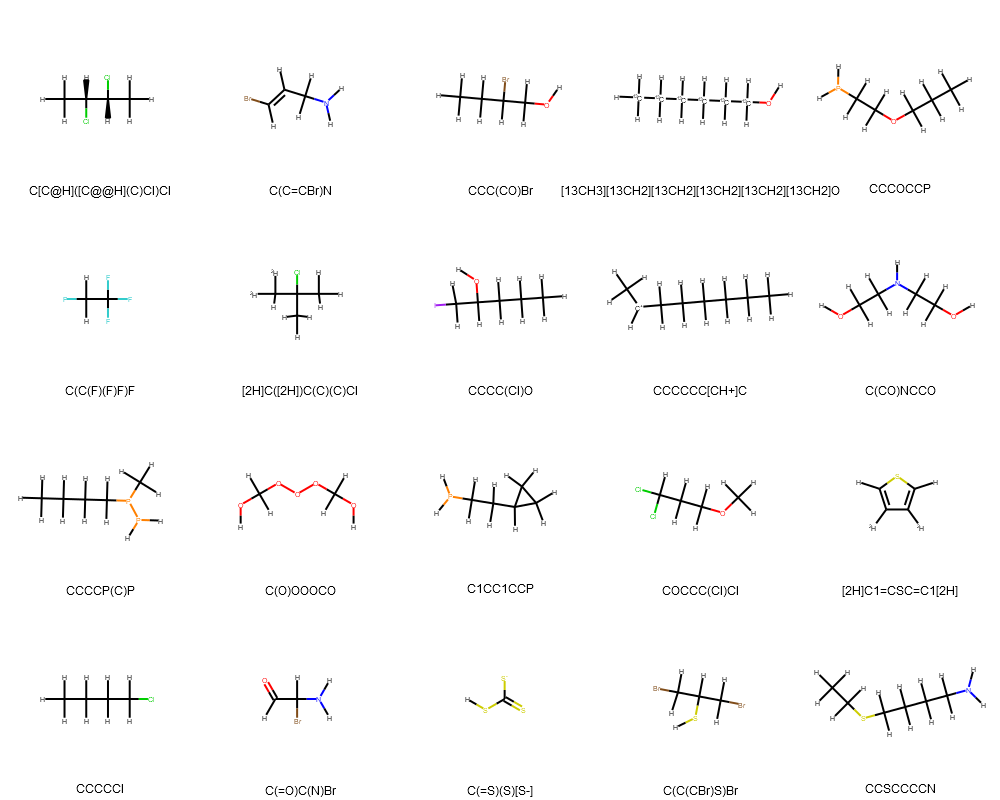

In [103]:
from rdkit.Chem import Draw
mols = df['mol'][:20]
Draw.MolsToGridImage(mols, molsPerRow=5, useSVG=False, legends=list(df['smiles'][:20].values))

**Numbers of atoms**

Since a size of a molecule can be approximated by a number of atoms in it, let's extract corresponding values from MOL.
RDkit provides ***GetNumAtoms()*** and ***GetNumHeavyAtoms()*** methods for that task.

In [113]:
# AddHs function adds H atoms to a MOL (as Hs in SMILES are usualy ignored)
# GetNumAtoms() method returns a general nubmer of all atoms in a molecule
# GetNumHeavyAtoms() method returns a nubmer of all atoms in a molecule with molecular weight > 1


df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))
df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
df['num_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())

Let's take look at how number of atoms is connected with target variable:

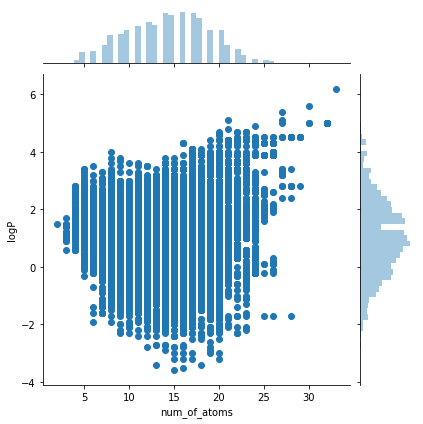

In [114]:
import seaborn as sns
sns.jointplot(df.num_of_atoms, df.logP)

plt.show()

No clear dependence is observed so we need some extra features to be exctracted.
The next obvious step is to count numbers of the most common atoms.
RDkit supports subpattern search represented by ***GetSubstructMatches()*** method. It takes a substructure pattern as an argument. So you can futher extract occurance of each pattern you'd like.

In [115]:
# First we need to settle the pattern.
c_patt = Chem.MolFromSmiles('C')

# Now let's implement GetSubstructMatches() method
print(df['mol'][0].GetSubstructMatches(c_patt))
df['mol'][0]

((0,), (1,), (2,), (3,))


As you see, selected patterns are marked. The method returns a tuple of tuples of positions of corresponding patterns. To extract the number of matches we need to take the length of a corresponding tuple of tuples.

In [116]:
#We're going to settle the function that searches patterns and use it for a list of most common atoms only
def number_of_atoms(atom_list, df):
    for i in atom_list:
        df['num_of_{}_atoms'.format(i)] = df['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

number_of_atoms(['C','O', 'N', 'Cl'], df)

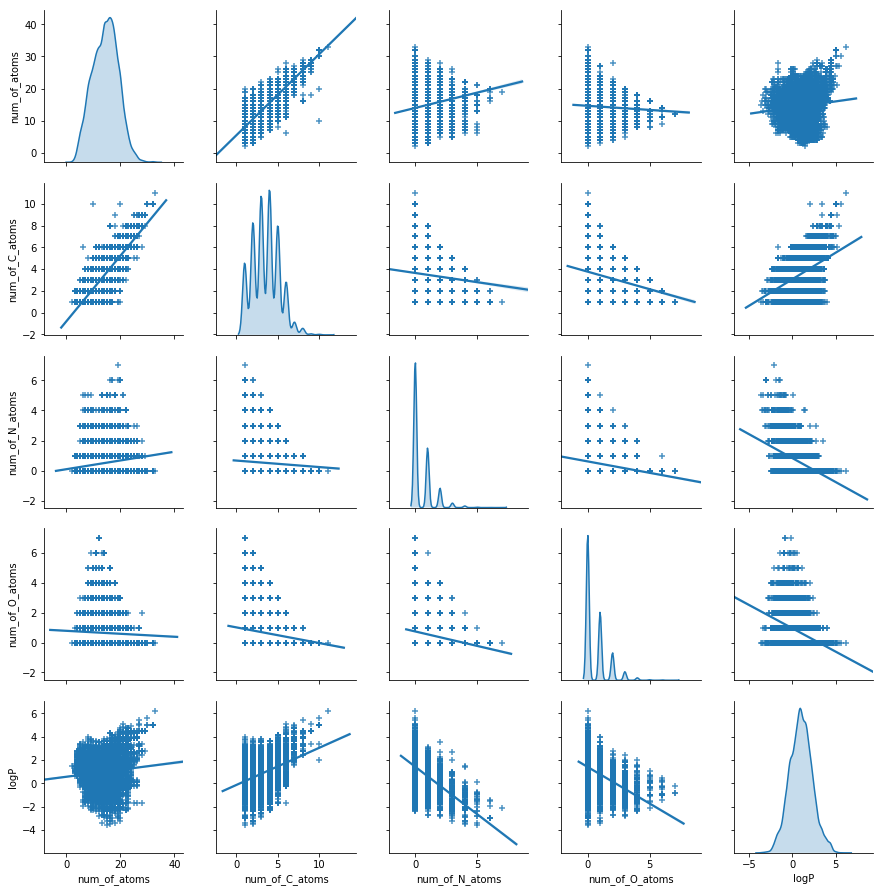

In [97]:
sns.pairplot(df[['num_of_atoms','num_of_C_atoms','num_of_N_atoms', 'num_of_O_atoms', 'logP']], diag_kind='kde', kind='reg', markers='+')
plt.show()

Looking at the bottom plots we notice  some linear dependence of logP on numbers of particular atoms. Let's build our first model.
We'll account for a ridge regression.

In [117]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split

#Leave only features columns
train_df = df.drop(columns=['smiles', 'mol', 'logP'])
y = df['logP'].values

print(train_df.columns)

#Perform a train-test split. We'll use 10% of the data to evaluate the model while training on 90%

X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=.1, random_state=1)


Index(['num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms', 'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms'], dtype='object')


Train the model and evaluate results. As an ealuation metric we can choose MAE or MSE.

In [118]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
def evaluation(model, X_test, y_test):
    prediction = model.predict(X_test)
    mae = mean_absolute_error(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)
    
    plt.figure(figsize=(15, 10))
    plt.plot(prediction[:300], "red", label="prediction", linewidth=1.0)
    plt.plot(y_test[:300], 'green', label="actual", linewidth=1.0)
    plt.legend()
    plt.ylabel('logP')
    plt.title("MAE {}, MSE {}".format(round(mae, 4), round(mse, 4)))
    plt.show()
    
    print('MAE score:', round(mae, 4))
    print('MSE score:', round(mse,4))

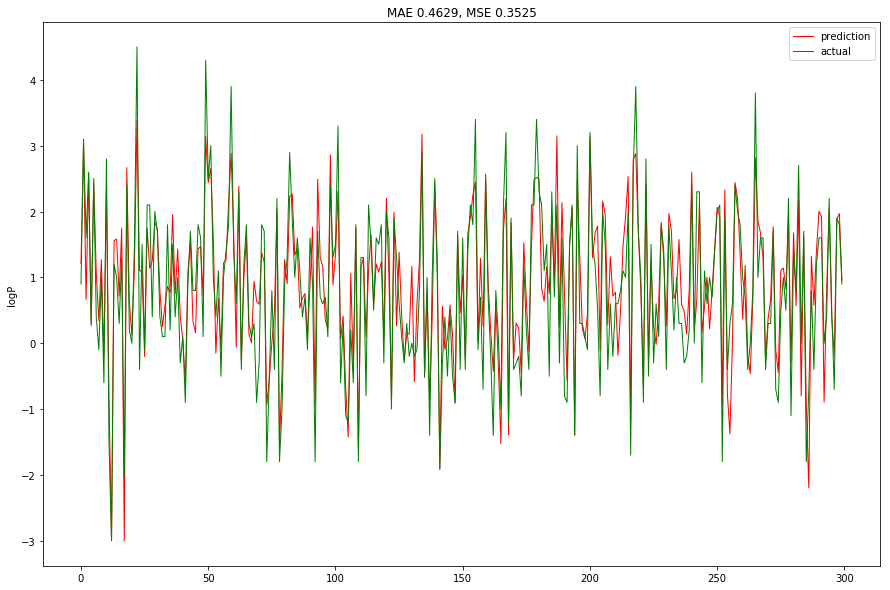

MAE score: 0.4629
MSE score: 0.3525


In [147]:
#Train the model
ridge = RidgeCV(cv=5)
ridge.fit(X_train, y_train)
#Evaluate results
evaluation(ridge, X_test, y_test)

Visualize model perfomance:

**Particular atoms, bonds and rings**

Note that you can also extract some ring information or iterate through each molecule's atoms and bonds with RDkit. Methods ***GetRingInfo()***, ***GetAtoms()*** and ***GetBonds()*** yield corresponding generators over rings and atoms in molecule. 

Some toy examples:

Number of rings with 1 backbone: 1
Number of rings with 2 backbones: 2


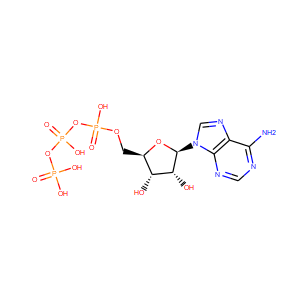

In [120]:
atp = Chem.MolFromSmiles('C1=NC2=C(C(=N1)N)N=CN2[C@H]3[C@@H]([C@@H]([C@H](O3)COP(=O)(O)OP(=O)(O)OP(=O)(O)O)O)O')

# Getting number of rings with specified number of backbones
print('Number of rings with 1 backbone:', atp.GetRingInfo().NumAtomRings(1))
print('Number of rings with 2 backbones:', atp.GetRingInfo().NumAtomRings(2))
Draw.MolToImage(atp)

Atom: C Valence: 3
Atom: O Valence: 2
Atom: C Valence: 4
Atom: N Valence: 2
Atom: C Valence: 2
Atom: Cl Valence: 1


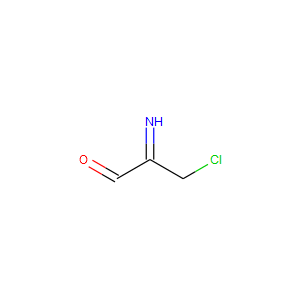

In [121]:
m = Chem.MolFromSmiles('C(=O)C(=N)CCl')
#Iterating through atoms to get atom symbols and explicit valencies 
for atom in m.GetAtoms():
    print('Atom:', atom.GetSymbol(), 'Valence:', atom.GetExplicitValence())
Draw.MolToImage(m)

**Descriptors**

***rdkit.Chem.Descriptors*** provides a number of general molecular descriptors that can also be used to featurize a molecule. Most of the descriptors are straightforward to use from Python.

Using this package we can add some useful features to our model:
- rdkit.Chem.Descriptors.TPSA() - the surface sum over all polar atoms or molecules also including their attached hydrogen atoms;
- rdkit.Chem.Descriptors.ExactMolWt() - exact molecural weight;
- rdkit.Chem.Descriptors.NumValenceElectrons() - number of valence electrons (may illustrate general electronic density)
- rdkit.Chem.Descriptors.NumHeteroatoms() - general number of non-carbon atoms.

In [122]:
from rdkit.Chem import Descriptors
df['tpsa'] = df['mol'].apply(lambda x: Descriptors.TPSA(x))
df['mol_w'] = df['mol'].apply(lambda x: Descriptors.ExactMolWt(x))
df['num_valence_electrons'] = df['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x))
df['num_heteroatoms'] = df['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))

Let's check the improvement of the model perfomance with new features.

In [145]:
train_df = df.drop(columns=['smiles', 'mol', 'logP'])
y = df['logP'].values

print(train_df.columns)

#Perform a train-test split. We'll use 10% of the data to evaluate the model while training on 90%

X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=.1, random_state=1)

Index(['num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms', 'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms', 'tpsa', 'mol_w', 'num_valence_electrons', 'num_heteroatoms'], dtype='object')


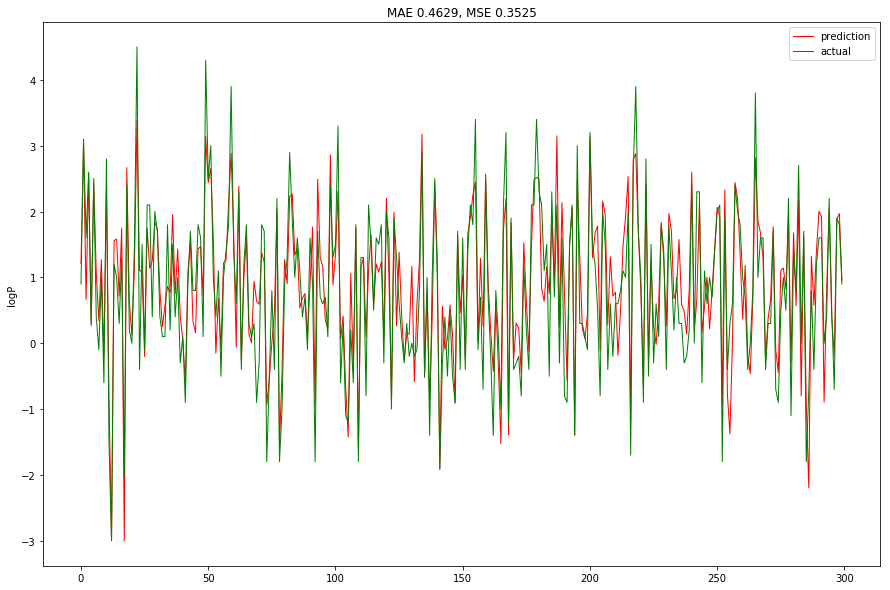

MAE score: 0.4629
MSE score: 0.3525


In [146]:
#Train the model
ridge = RidgeCV(cv=5)
ridge.fit(X_train, y_train)
#Evaluate results and plot predictions
evaluation(ridge, X_test, y_test)

**Summimg up**

RDkit is a wonderful kit to work with chemical data, especially represented as SMILES strings or in MOL format. We've seen some basic general abilities of the package but some other powerful tools are yet to find in the docs.

Trying to improve our model perfomance at the next step we'll take a look at a copletely different way to featurize molecules. 

# mol2vec - learning vector representations of molecular subctructures

From package description 'Mol2vec is an unsupervised machine learning approach to obtain hight dimensional embeddings of chemical substructures. It is based on word2vec algorithm and if word2vec learns such embeddings that vectors representing similar words group together, so should Mol2vec learn substructure embeddings where vectors of chemically related substructures end up close in vector space'. 

In other words mol2vec takes inspiration in one of the most widespread NLP technique.
Without going deep in deatials we can describe the process as following: 

**1.** A molecule is divided into substructures of a fixed radius (usually encoding distance to other atoms in bonds, i.e. radius = 1 represents a single heavy atom or a group of atoms around  heavy atom), substructures are encoded via Morgan fingerprints with the help or RDkit.

**2.** These encoded substructures are fed to Word2vec yielding vector representations of substructures in a number of dimensions.

**3.** Summing up substructure vectors we get vector representations of whole molecules.


The main idea behind is that we can use vector representations of molecules in different dimensions as features in supervised learning, supposing similar molecules will have close vector representations and will have close target values. 

Another wonderful point is that mol2vec provides a pre-trained model which has learned 20M different compounds with a radius=1 for Morgan fingerprints.

We'll start from scratch with initial dataset.

In [127]:
#Load the dataset and extract target values
mdf= pd.read_csv('logP_dataset.csv', names=['smiles', 
                                           'target'])
target = mdf['target']
mdf.drop(columns='target',inplace=True)

Once again we need to transform SMILES representations to MOL.

In [128]:
#Transforming SMILES to MOL
mdf['mol'] = mdf['smiles'].apply(lambda x: Chem.MolFromSmiles(x))


Now we'll load a pre-trained mol2vec model. It's trained with radius=1 for Morgan fingerprints to yield 300 dimensional embeddings.

In [129]:
#Loading pre-trained model via word2vec
model = word2vec.Word2Vec.load('model_300dim.pkl')

Importing necessary functions. 

***mol2alt_sentence()*** constructs a so-called 'molecular sentence' with desired Morgan fingerprints' radius (uses rdkit backend) where 'words' are unique substructure identifiers; ***MolSentence()*** is an internal wrapper function; ***sentences2vec()*** generates molecular embeddings with the help of the trained model; ***DfVec()*** is an internal wrapper for embeddings' generator (attribute .vec yields aggregated vectors).  

In [130]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec
print('Molecular sentence:', mol2alt_sentence(mdf['mol'][1], radius=1))
print('\nMolSentence object:', MolSentence(mol2alt_sentence(mdf['mol'][1], radius=1)))
print('\nDfVec object:',DfVec(sentences2vec(MolSentence(mol2alt_sentence(mdf['mol'][1], radius=1)), model, unseen='UNK')))

Molecular sentence: ['2245384272', '772923822', '2246703798', '530246988', '2246703798', '1211882010', '3612926680', '318583445', '847957139', '2592785365']

MolSentence object: MolSentence with 10 words

DfVec object: (10, 300) dimensional vector


Now let's implement those functions above and construct a feature matrix of vector representations.

In [131]:
#Constructing sentences
mdf['sentence'] = mdf.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)

#Extracting embeddings to a numpy.array
#Note that we always should mark unseen='UNK' in sentence2vec() so that model is taught how to handle unknown substructures
mdf['mol2vec'] = [DfVec(x) for x in sentences2vec(mdf['sentence'], model, unseen='UNK')]
X = np.array([x.vec for x in mdf['mol2vec']])
y = target.values

X.shape

(14610, 300)

Let's see the perfomance of the model with vector representations.

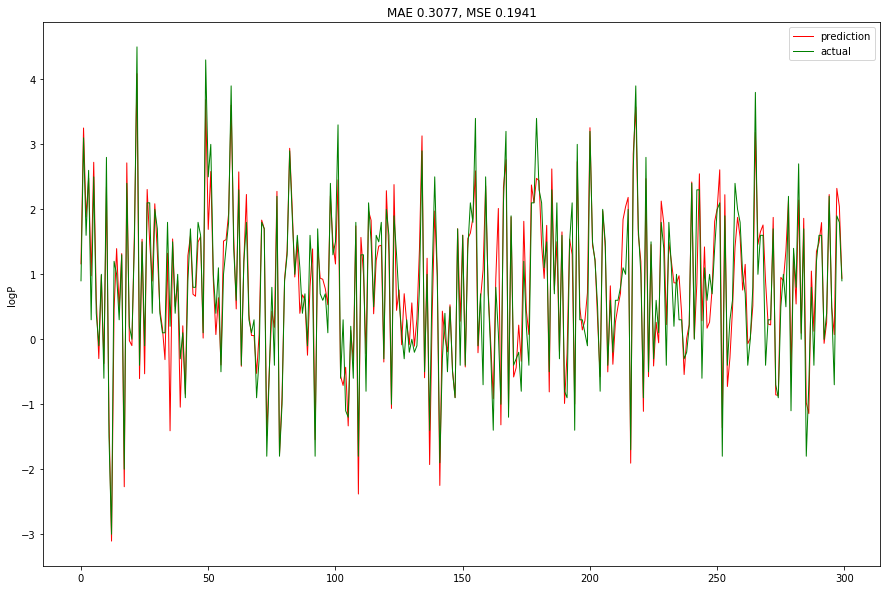

MAE score: 0.3077
MSE score: 0.1941


In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=1)
ridge = RidgeCV(cv=5)
ridge.fit(X_train, y_train)
evaluation(ridge, X_test, y_test)

Wow! Vector representations alone absolutely outscored features built with chemical logic. mol2vec is a really powerful tool!

Now let's put embeddings together with constructed logical features to see the result.

In [149]:
mdf = pd.DataFrame(X)
new_df = pd.concat((mdf, train_df), axis=1)

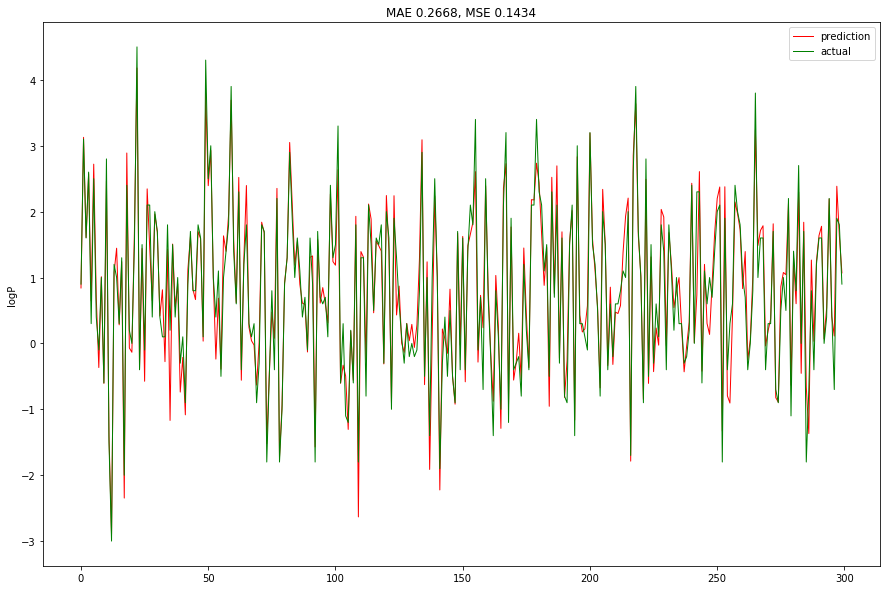

MAE score: 0.2668
MSE score: 0.1434


In [150]:
X_train, X_test, y_train, y_test = train_test_split(new_df, y, test_size=.1, random_state=1)
ridge = RidgeCV(cv=5)
ridge.fit(X_train, y_train)
evaluation(ridge, X_test, y_test)

And we got the best among our results. This one is actually a rather good starting point.

# Conclusion

We've tried a number of approaches to handle chemical data and built rather good predictive models for physical properties of chemical matter with wonderful ***RDkit*** and ***mol2vec*** packages. I suppose, further feature construction can bring an even better result, but still it's shown that we are able to predict important general properties rather fast and easy, without constructing great neural networks or spending weeks on quantum calculations, which can actually be implemented in a lab if an approximated evaluation of the target is needed. Also I'd like to mention that ***RDkit*** allows to do many useful things that are not shown in the kernel, thus, are yet to research, if needed. The docs can be found here and here. 

Will ***mol2vec*** approach be useful in QSAR problems solving is a question to research. But still it's a good thing to start with when it comes to ML in chemistry.

Thanks for your attention!

**References**:
 - Jaeger, S., Fulle, S., & Turk, S. (2018). Mol2vec: Unsupervised machine learning approach with chemical intuition. Journal of chemical information and modeling, 58(1), 27-35. URL = {http://dx.doi.org/10.1021/acs.jcim.7b00616}, eprint = {http://dx.doi.org/10.1021/acs.jcim.7b00616}